# Introduction

In this notebook, the Stack Overflow developer Survey of 2024 dataset is being used.
Using the *CRISP-DM*, the questions are the following:
1. How does total compensation (salary) differ by remote work type (remote, hybrid, onsite)?
2. How does job satisfaction vary across different remote work types (remote, hybrid, onsite)?
3. What is the relationship between remote work type and the likelihood of adopting AI tools in the development workflow?
4. Additional comparisons

Well, with that being said, the RemoteWork column has our main focus. 

Any row without Salary **and** Job Satisfaction will be neglected. 

## Let's get Started

### Import useful Libraries

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline


### Gether data

In [33]:
#Reading the Survey data
df = pd.read_csv("survey_results_public.csv", index_col = "ResponseId")
df.shape

(65437, 113)


    
To make the data fully appeared in the question field of the schema DataFrame.
use the following line 
`pd.options.display.max_colwidth = 250`

The following was helping me for understaning the columns.


In [29]:
#Schema is a DataFrame that contains the survey questions with the columns' names.
schema = pd.read_csv("survey_results_schema.csv")
schema.shape

(87, 6)


We have 87 questions, 65437 developer have submited the survey.



In [4]:
# After Reading the survey questions, I'd like to know which column contains what. This function should help.
def find_column(question):
    
    return schema[schema['question'] == question]['qname']

### Assess Data

In [5]:
#Wondering what might the column name would be...
find_column('Which best describes your current work situation?')

3    RemoteWork
Name: qname, dtype: object

In [6]:
#Wondering what might the column name would be...
find_column('Which of the following describes your current job, the one you do most of the time? Please select only one.')

12    DevType
Name: qname, dtype: object

In [7]:
#Wondering what might the column name would be...
find_column('How satisfied are you in your current professional developer role?')

61    JobSat
Name: qname, dtype: object

In [8]:
#Wondering what might the column name would be...
find_column('What is your current total <b>annual</b> compensation (salary, bonuses, and perks, before taxes and deductions)? Please enter a whole number in the box below, without any punctuation.  If you are paid hourly, please estimate an equivalent yearly salary. If you prefer not to answer, please leave the box empty. ')

20    CompTotal
Name: qname, dtype: object

In [9]:
df.groupby('DevType')['CompTotal'].mean().sort_values()

DevType
Student                                           2.308532e+05
Scientist                                         3.987775e+05
Developer Experience                              5.699677e+05
Developer Advocate                                6.508846e+05
Product manager                                   1.314249e+06
Marketing or sales professional                   1.612822e+06
Educator                                          2.527086e+06
Engineer, site reliability                        2.795808e+06
Data scientist or machine learning specialist     2.874761e+06
Research & Development role                       3.003586e+06
Data engineer                                     5.825054e+06
Engineering manager                               6.017651e+06
Developer, embedded applications or devices       6.644836e+06
Data or business analyst                          7.960099e+06
Developer, game or graphics                       1.267149e+07
Developer, desktop or enterprise applications  

**Checking to make sure the developer is paying attention to the survey questions.**

In [10]:
df[df['Check'] != 'Apples']

,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
ResponseId,,,,,,,,,,,,,,,,,,,,,


In [11]:
df['RemoteWork'].isna().mean()

0.16246160429115028

In [12]:
df.groupby('RemoteWork')['CompTotal'].mean()

RemoteWork
Hybrid (some remote, some in-person)    6.951686e+145
In-person                                2.101327e+11
Remote                                   7.303535e+15
Name: CompTotal, dtype: float64

## Clean Data
*Given the context, it's important to note that the data appears to be containing a fabricated values. The numbers presented are highly unrealistic, suggesting that the dataset may not reflect real-world values.*

*In other words, there are numerous **outliers** in the data.*

Here's a summary of the steps I followed:

1. Removing Missing Data: 
    The dataset contained missing values in critical fields like RemoteWork, CompTotal (compensation), and JobSat (job satisfaction). Rows with missing values in these fields were dropped to ensure the analysis is based on complete information.
    
2. Dropping Columns with Excessive Missing Data: 
    Columns where more than 80% of the data was missing were removed, as they would not provide meaningful insights.
    
3. Handling Outliers in Compensation Data:
    Compensation data (CompTotal) showed extreme outliers, especially with some values being abnormally high. To address this, I applied the Interquartile Range (IQR) method to remove outliers for each job type. This ensures that the data reflects typical compensation within each job type, without being skewed by extreme values.
    Here's the logic behind the outlier removal:
    I calculated the first quartile (Q1) and third quartile (Q3) for CompTotal within each job type.
    I computed the IQR (Q3 - Q1) and used it to define a lower and upper bound (1.5 * IQR beyond Q1 and Q3).
    Rows with CompTotal values outside these bounds were considered outliers and removed.

By following these steps, I ensured that the data used for analysis is both accurate and reliable, reflecting reasonable compensation ranges and complete information for key fields.

In [13]:
data = df
data.dropna(subset = ['RemoteWork'], axis = 0, inplace = True)
data.dropna(subset = ['CompTotal', 'JobSat'], how = 'all', inplace = True)
data.drop(columns = data.columns[data.isna().mean() > 0.8], axis = 1, inplace = True)

In [14]:
# Define a function to calculate and filter out outliers based on IQR
def remove_outliers_by_job_type(group):
    """
    Removes outliers from a DataFrame group based on the Interquartile Range (IQR) of the 'CompTotal' column.

    This function calculates the first quartile (Q1) and the third quartile (Q3) of the 'CompTotal' column for each group.
    It then computes the IQR as the difference between Q3 and Q1. Outliers are defined as values outside the range
    [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]. Rows where 'CompTotal' falls within this range are kept, and rows with
    'CompTotal' outside this range are removed.

    Args:
    group (pandas.DataFrame): A DataFrame subset belonging to a specific job type, with at least the 'CompTotal' column.

    Returns:
    pandas.DataFrame: A DataFrame with outliers removed, containing only rows where 'CompTotal' is within the IQR range.
    """
    Q1 = group['CompTotal'].quantile(0.25)
    Q3 = group['CompTotal'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5* IQR
    # Filter rows within the IQR range
    return group[(group['CompTotal'] >= lower_bound) & (group['CompTotal'] <= upper_bound)]


# Apply the function to each DevType group
data_cleaned = data.groupby('DevType').apply(remove_outliers_by_job_type).reset_index(drop=True)

# Check the result
data_cleaned.groupby('RemoteWork')['CompTotal'].mean().sort_values()

RemoteWork
Hybrid (some remote, some in-person)    119351.822510
In-person                               127196.363615
Remote                                  129659.801321
Name: CompTotal, dtype: float64

*These numbers seems somehow realistic for a moment.*

As noticed now the student average salary is almost $25k which is more realistic than 230k. 
Not to mention the Developer- fullstack.

In [15]:
data_cleaned.groupby('DevType')['CompTotal'].mean().sort_values()

DevType
Student                                           24883.396648
Academic researcher                               57032.183099
System administrator                              76934.291457
Educator                                          77207.481752
Designer                                          90160.037037
Data or business analyst                          92123.948052
Scientist                                         94378.428571
Developer, embedded applications or devices      101798.380688
Developer, full-stack                            103620.207016
Developer, desktop or enterprise applications    105565.327586
Database administrator                           109175.250000
Hardware Engineer                                109899.364706
DevOps specialist                                111112.611307
Data engineer                                    111719.184170
Developer, game or graphics                      112740.403636
Data scientist or machine learning specialist  

## Analysis 
    With some visuals for a better understanding

### Question 1
    How does total compensation (salary) differ by remote work type (remote, hybrid, onsite)?

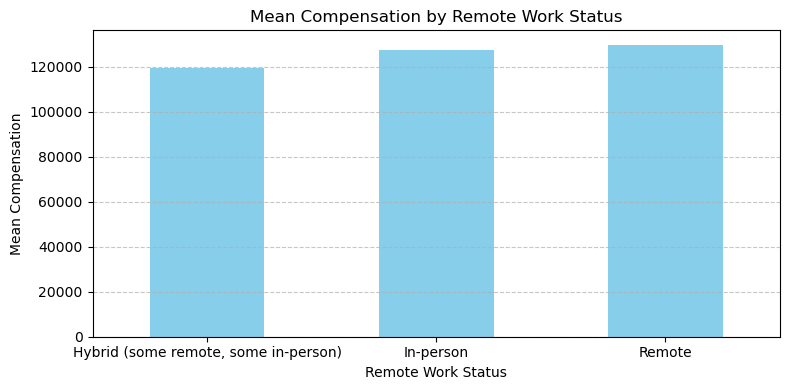

In [16]:
# Compute the means for the developers grouped by the type of the work whether it is remote.
means = data_cleaned.groupby('RemoteWork')['CompTotal'].mean().sort_values()

# Plot the bar chart
plt.figure(figsize=(8, 4))
means.plot(kind='bar', color='skyblue')
plt.title('Mean Compensation by Remote Work Status')
plt.xlabel('Remote Work Status')
plt.ylabel('Mean Compensation')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to fit labels and titles

# Show the plot
plt.show()

### Key Insights:
    Remote workers tend to earn the highest salaries, especially in regions with higher living costs.
    Onsite workers often receive less, likely due to limited access to global job markets and salary standardization across regions.

#### To better understand the distribution of salary ranges, a box plot can be used.

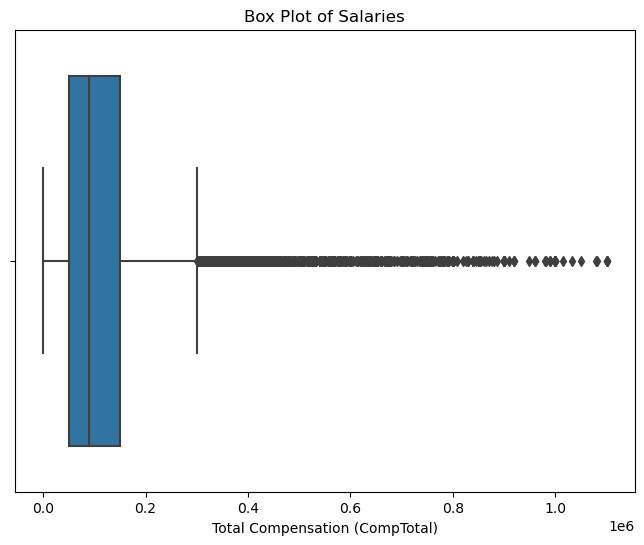

In [17]:
salaries = data_cleaned['CompTotal']

# Plot a box plot to visualize the distribution and outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=salaries)
plt.title('Box Plot of Salaries')
plt.xlabel('Total Compensation (CompTotal)')
plt.show()

We still have outliers but at least, realistic numbers.
### Question 2
    How does job satisfaction vary across different remote work types (remote, hybrid, onsite)?

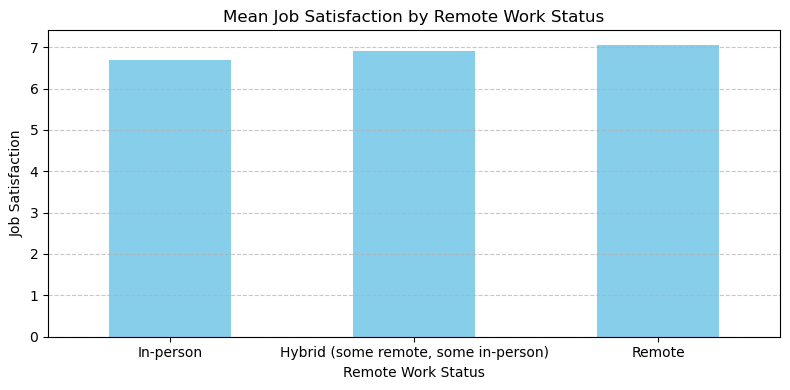

In [18]:
# Plot the bar chart
plt.figure(figsize=(8, 4))

#To answer such a question, we need to start gouping the JobSat by the job type whether it is remote.
#After that we can use the plot function to plot a bar chart.
data_cleaned.groupby('RemoteWork')['JobSat'].mean().sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Job Satisfaction by Remote Work Status')
plt.xlabel('Remote Work Status')
plt.ylabel('Job Satisfaction')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to fit labels and titles

# Show the plot
plt.show()

### Key Insights:
    Remote and hybrid workers report higher satisfaction scores, likely due to the flexibility and autonomy of their roles.
    Onsite workers, while still satisfied, are more likely to cite stress related to commutes and office environments.

We might also consider using a **heatmap** to visualize job satisfaction across different work types.

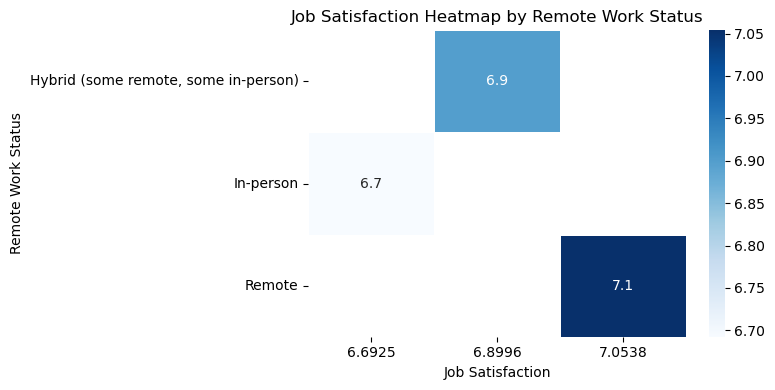

In [19]:
# Create a pivot table with 'RemoteWork' and the mean of 'JobSat'
pivot_data = data_cleaned.groupby('RemoteWork')['JobSat'].mean().round(4).reset_index()

pivot_data = pivot_data.pivot(index='RemoteWork', columns='JobSat', values='JobSat')

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5)

# Add titles and labels
plt.title('Job Satisfaction Heatmap by Remote Work Status')
plt.xlabel('Job Satisfaction')
plt.ylabel('Remote Work Status')

# Show the plot
plt.tight_layout()
plt.show()

### Question 3
    What is the relationship between remote work type and the likelihood of adopting AI tools in the development workflow?  
Let's get to know which column are we going to focus on this time

In [20]:
#Wondering what might the column name would be...
find_column('Do you currently use AI tools in your development process? *')


39    AISelect
Name: qname, dtype: object

In [21]:
#This is what the answers are divided into.
data_cleaned['AISelect'].value_counts()

AISelect
Yes                        17322
No, and I don't plan to     7050
No, but I plan to soon      3528
Name: count, dtype: int64

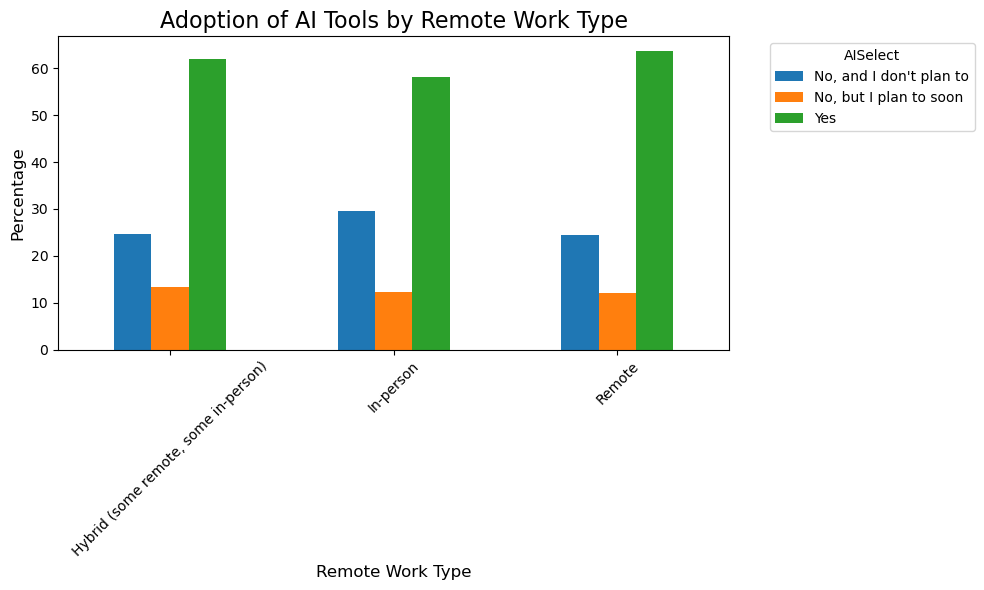

In [22]:
# Unstack the multi-index Series to pivot AISelect into columns
df_plot = data_cleaned.groupby('RemoteWork')['AISelect'].value_counts(normalize = True).unstack() *100

# Plot a grouped bar chart
df_plot.plot(kind='bar', stacked=False, figsize=(10, 6))

# Add labels and title
plt.title('Adoption of AI Tools by Remote Work Type', fontsize=16)
plt.xlabel('Remote Work Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='AISelect', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()

### Key Insights:
    Remote workers are the most likely to embrace AI tools, reflecting the innovative nature of their roles.
    Onsite workers have the highest percentage in rejecting the future of using AI in their work.

### Question 4 
    Additional Comparisons

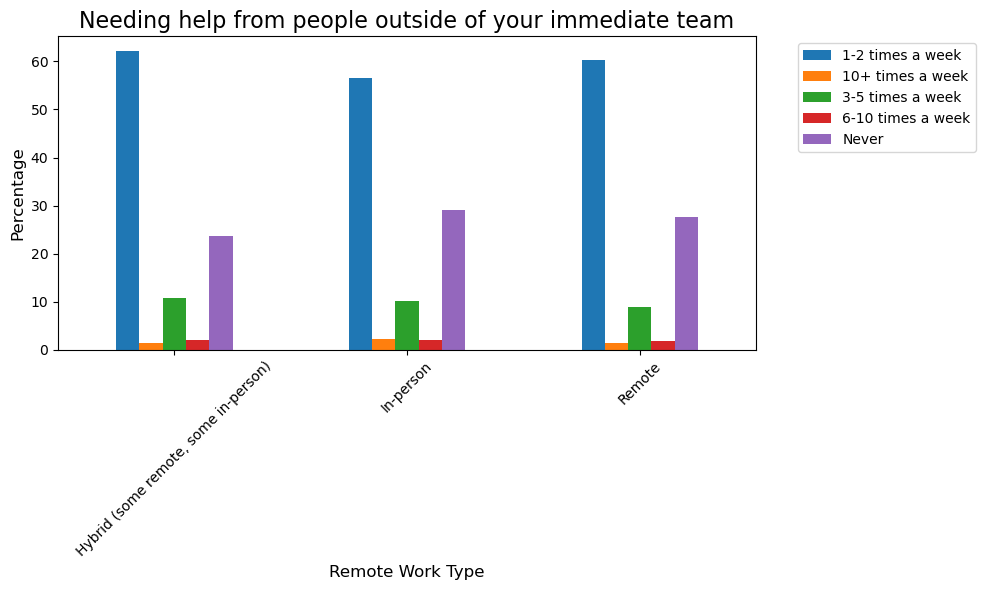

In [23]:
 '''
 In this comparison we are using Frequency_1 column which is used to answer the following question:
 Needing help from people outside of your immediate team?
 Again, this is grouped with RemoteWork values.
 '''
df_ploting = data_cleaned.groupby('RemoteWork')['Frequency_1'].value_counts(normalize = True).unstack() *100

df_ploting.plot(kind='bar', stacked=False, figsize=(10, 6))

# Add labels and title
plt.title('Needing help from people outside of your immediate team', fontsize=16)
plt.xlabel('Remote Work Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()

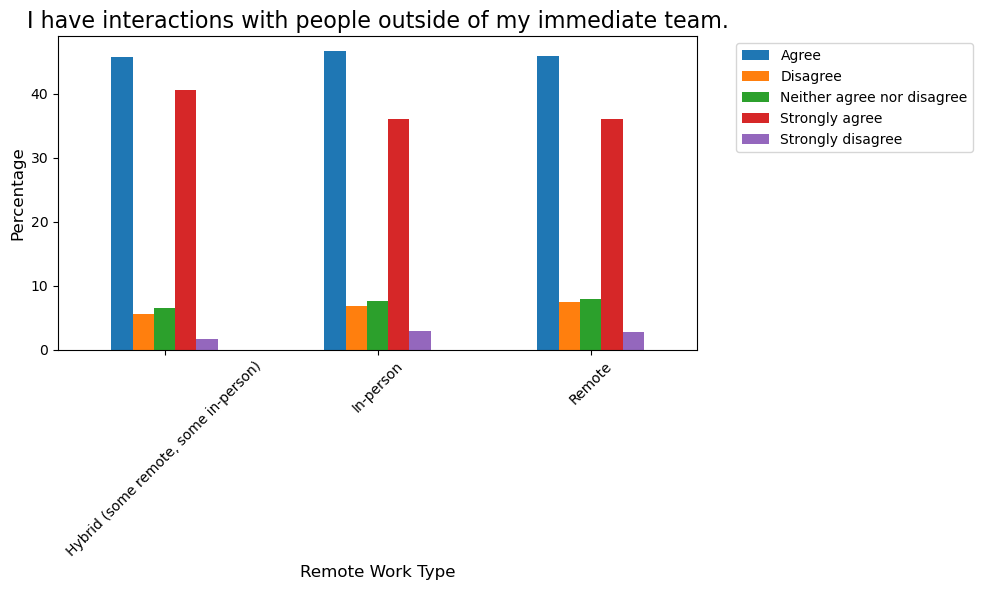

In [24]:
'''
 In this comparison we are using Knowledge_1 column which is used to state how likely this happen:
 I have interactions with people outside of my immediate team
 Again, this is grouped with RemoteWork values.
 '''
df_ploting = data_cleaned.groupby('RemoteWork')['Knowledge_1'].value_counts(normalize = True).unstack() *100

df_ploting.plot(kind='bar', stacked=False, figsize=(10, 6))

# Add labels and title
plt.title('I have interactions with people outside of my immediate team.', fontsize=16)
plt.xlabel('Remote Work Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()

## What is next?
    We could utilize data from 2021, 2022, and 2023 to explore the emerging trend of remote work. By applying data modeling techniques, we can estimate missing values and project trends for 2025.